In [1]:
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import random
import sys
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm

# sys.argv=['']
HOME_DIR = os.getenv('HOME')
DATA_DIR = '{}/research_backup/pytorch-transformers/data'.format(os.getenv('HOME'))

In [2]:
import sys
import ujson as json
import re
import string
from collections import Counter
import pickle

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def update_answer(metrics, prediction, gold):
    em = exact_match_score(prediction, gold)
    f1, prec, recall = f1_score(prediction, gold)
    metrics['em'] += float(em)
    metrics['f1'] += f1
    metrics['prec'] += prec
    metrics['recall'] += recall
    metrics['total'] += 1
    return em, prec, recall, f1

def update_sp(metrics, prediction, gold):
    cur_sp_pred = set(map(tuple, prediction))
    gold_sp_pred = set(map(tuple, gold))
    tp, fp, fn = 0, 0, 0
    for e in cur_sp_pred:
        if e in gold_sp_pred:
            tp += 1
        else:
            fp += 1
    for e in gold_sp_pred:
        if e not in cur_sp_pred:
            fn += 1
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    metrics['sp_em'] += em
    metrics['sp_f1'] += f1
    metrics['sp_prec'] += prec
    metrics['sp_recall'] += recall
    return em, prec, recall

def eval(prediction_file, gold_file):
    with open(prediction_file) as f:
        prediction = json.load(f)
    with open(gold_file) as f:
        gold = json.load(f)
    with open('/'.join(gold_file.split('/')[:-1] + ['hotpot_dev_1hop_solv_nonsolv.json'])) as f:
        onehop_ids = set(json.load(f)['1hop_solv'])

    metrics = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0, 'total': 0,
        'sp_em': 0, 'sp_f1': 0, 'sp_prec': 0, 'sp_recall': 0,
        'joint_em': 0, 'joint_f1': 0, 'joint_prec': 0, 'joint_recall': 0}
    subset_metrics = {subset: {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0, 'total': 0}
                      for subset in ['bridge', 'comparison', 'onehop', 'multihop']}
    for dp in gold:
        cur_id = dp['_id']
        can_eval_joint = True
        if cur_id not in prediction['answer']:
            print('missing answer {}'.format(cur_id))
            can_eval_joint = False
        else:
            em, prec, recall, f1 = update_answer(
                metrics, prediction['answer'][cur_id], dp['answer'])
            _ = update_answer(
                subset_metrics['onehop' if cur_id in onehop_ids else 'multihop'],
                prediction['answer'][cur_id], dp['answer'])
            _ = update_answer(
                subset_metrics[dp['type']], prediction['answer'][cur_id], dp['answer'])
        if cur_id not in prediction['sp']:
            print('missing sp fact {}'.format(cur_id))
            can_eval_joint = False
        else:
            sp_em, sp_prec, sp_recall = update_sp(
                metrics, prediction['sp'][cur_id], dp['supporting_facts'])

        if can_eval_joint:
            joint_prec = prec * sp_prec
            joint_recall = recall * sp_recall
            if joint_prec + joint_recall > 0:
                joint_f1 = 2 * joint_prec * joint_recall / (joint_prec + joint_recall)
            else:
                joint_f1 = 0.
            joint_em = em * sp_em

            metrics['joint_em'] += joint_em
            metrics['joint_f1'] += joint_f1
            metrics['joint_prec'] += joint_prec
            metrics['joint_recall'] += joint_recall

    N = len(gold)
    for k in metrics.keys():
        metrics[k] /= N
    metrics.pop('total')
    for subset in subset_metrics.keys():
        for k in subset_metrics[subset].keys():
            if (k != 'total') and (subset_metrics[subset]['total'] != 0):
                metrics[subset + '_' + k] = subset_metrics[subset][k] / subset_metrics[subset]['total']

#     print(json.dumps(metrics, indent=2, sort_keys=True))
    return metrics

In [208]:
parser = argparse.ArgumentParser()
parser.add_argument("--pred_answer_file_pattern",
                    default=None,  # Default file pattern is set later if no flag passed.
                    type=str,
                    help="Pattern for files to aggregate. Replace seed value for '{}'.")
parser.add_argument("--num_seeds",
                    default=10,  # TODO: Sweep
                    type=int,
                    help="Ensemble over first N seeds")
parser.add_argument("--decay_factor",
                    default=1.0,  # TODO: Sweep
                    type=float,
                    help="How much to decay influence of later runs compared to earlier runs")
parser.add_argument("--num_train",
                    default=17435,  # TODO: Sweep: 1090 2179 4359 8718 17435
                    type=int,
                    help="Number of model training examples")
parser.add_argument("--beam",
                    default=10,
                    type=int,
                    help="Beam size used for generations")
parser.add_argument("--sample_temperature",
                    default=0.0,
                    type=float,
                    help="Softmax temperature used for sampling generations")
args = parser.parse_args()


# Set filename if necessary
learning_rate = '2e-5' if args.num_train == 17435 else '3e-5'
empty = '{}'
if args.pred_answer_file_pattern is None:
    args.pred_answer_file_pattern = f'{HOME_DIR}/research_backup/pytorch-transformers/checkpoint/v4.eval.num_shards=10.tn=hotpot-all.umt.comparison.paired.model=1.st={args.sample_temperature}.beam={args.beam}.lp=1.0.seed={empty}.q-predsubqs-predsubas.suba1=0.suba2=0.bs=16.lr={learning_rate}.nt={args.num_train}.st={args.sample_temperature}.seed={empty}/hotpot_predictions_.json'

# Read in answers into a user-friendly data structure
num_sample_answers = []
qid2answer2weight = {}
for seed in range(1, 1 + args.num_seeds):
    with open(args.pred_answer_file_pattern.format(seed, seed)) as f:
        sample_answers = json.load(f)['answer']
    
    num_sample_answers.append(len(sample_answers))
    for qid, answer in sample_answers.items():
        qid2answer2weight[qid] = qid2answer2weight.get(qid, {})
        qid2answer2weight[qid][answer] = qid2answer2weight[qid].get(answer, 0)
        qid2answer2weight[qid][answer] += args.decay_factor ** (seed - 1)

assert len(set(num_sample_answers)) == 1, 'Some samples do not have the same number of predicted answers!'
num_answers = num_sample_answers[0]

In [205]:
# How often is there a weird answer?
answer2count = {}
for qid, answer2weight in qid2answer2weight.items():
    for answer, weight in answer2weight.items():
        if answer in {'yes', 'no', 'yes no'}:
            answer2count[answer] = answer2count.get(answer, 0)
            answer2count[answer] += 1
        for answer_start in ['no ', 'yes no ']:
            if answer.startswith(answer_start):
                answer2count[answer_start] = answer2count.get(answer_start, 0)
                answer2count[answer_start] += 1
# pprint(answer2count)
yes_no_extra = (answer2count['no '] + answer2count['yes no '] + answer2count['yes no']) / float((sum(answer2count.values())))
# print(f'{round(100 * yes_no_extra, 2)}% yes/no answers with extra text')

{'no': 556, 'no ': 23, 'yes': 367, 'yes no': 15, 'yes no ': 7}
4.65% yes/no answers with extra text


{3: 0.00040513166779203237,
 4: 0.0009453072248480755,
 5: 0.0037812288993923047,
 6: 0.007427413909520602,
 7: 0.009993247805536811,
 8: 0.013234301147873075,
 9: 0.022687373396353846,
 10: 0.9415259959486009}


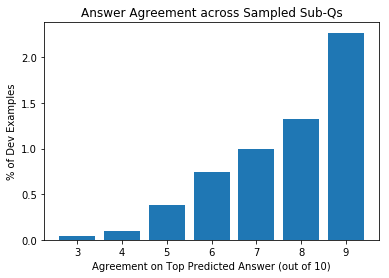

In [206]:
weightdist2count = {}
for qid, answer2weight in qid2answer2weight.items():
    weightdist = max(answer2weight.values())
#     weightdist.sort(reverse=True)
#     weightdist = tuple(weightdist)
    weightdist2count[weightdist] = weightdist2count.get(weightdist, 0)
    weightdist2count[weightdist] += 1. / num_answers
# pprint(weightdist2count)

# Plot
x, y = zip(*sorted(weightdist2count.items()))
x = np.array(x)
y = np.array(y) * 100.

plt.bar(x[:-1], y[:-1])
plt.title('Answer Agreement across Sampled Sub-Qs')
plt.xlabel('Agreement on Top Predicted Answer (out of 10)')
plt.ylabel('% of Dev Examples')
plt.savefig('/Users/ethanperez/research_backup/scripts/answer-agreement-across-sampled-sub-qs.png', dpi=200)
# plt.show()

In [207]:
# Get best answer based on counts
pred_answer_dict = {'answer': {}, 'sp': {}}
for qid, answer2weight in qid2answer2weight.items():
    pred_answer_dict['answer'][qid] = max(answer2weight.items(), key=operator.itemgetter(1))[0]
    pred_answer_dict['sp'][qid] = []

# Write answer to file
pred_answer_filename = f'/Users/ethanperez/research_backup/scripts/ensembled_answers/nt={args.num_train}.st={args.sample_temperature}.num_seeds={args.num_seeds}.json'
with open(pred_answer_filename, 'w') as f:
    json.dump(pred_answer_dict, f)

# Evaluate
pred_answer_results = eval(pred_answer_filename, '/Users/ethanperez/research_backup/pytorch-transformers/data/hotpot-orig/dev.json')
print(f'nt={args.num_train} ns={args.num_seeds} df={args.decay_factor}:', 100. * pred_answer_results['comparison_f1'])

{
  "bridge_em":0.0153768165,
  "bridge_f1":0.0397007157,
  "bridge_prec":0.0403085528,
  "bridge_recall":0.0530987909,
  "comparison_em":0.6442501681,
  "comparison_f1":0.701222665,
  "comparison_prec":0.7160318722,
  "comparison_recall":0.7071567262,
  "em":0.1416610398,
  "f1":0.1725411126,
  "joint_em":0.0,
  "joint_f1":0.0,
  "joint_prec":0.0,
  "joint_recall":0.0,
  "multihop_em":0.2053279719,
  "multihop_f1":0.2303561326,
  "multihop_prec":0.2342228927,
  "multihop_recall":0.2388764082,
  "onehop_em":0.0677174548,
  "onehop_f1":0.1053940126,
  "onehop_prec":0.1083807704,
  "onehop_recall":0.1212175914,
  "prec":0.1760007305,
  "recall":0.1844403371,
  "sp_em":0.0,
  "sp_f1":0.0,
  "sp_prec":0.0,
  "sp_recall":0.0
}
comparison_f1: 70.12226650232294
